In [1]:
import sys

# Change path to wherever you have repo locally
sys.path.append('/oak/stanford/groups/engreitz/Users/ymo/Tools/gene_network_evaluation/src')

from plotting import ( load_cNMF_stablity_error_data, plot_cNMF_stablity_error,\
                               load_enrichment_data, plot_enrichment,\
                               load_perturbation_data, plot_perturbation,\
                               load_explained_variance_data,plot_explained_variance
                          )

/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_directory = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation/batch"
run_name = "092525_100k_cells_10iter_torch_halsvar_batch_e8_RTX"
folder = f"{output_directory}/{run_name}/Eval"
components = [30, 50, 60, 80, 100, 200, 250, 300]


# Stability & Error

In [3]:
stat = load_cNMF_stablity_error_data( output_directory = output_directory, run_name = run_name, components = components, 
density_threshold = 2.0, local_neighborhood_size = 0.3)
stat

Using sklearn nmf coordinate descent to refit
sklearn refit completed
Using sklearn nmf coordinate descent to refit
sklearn refit completed
Using sklearn nmf coordinate descent to refit
sklearn refit completed
Using sklearn nmf coordinate descent to refit
sklearn refit completed
Using sklearn nmf coordinate descent to refit
sklearn refit completed
Using sklearn nmf coordinate descent to refit
sklearn refit completed
Using sklearn nmf coordinate descent to refit


In [4]:

plot_cNMF_stablity_error(stats)

# Enrichement tests

min go_terms is 679
max go_terms is 859
min genesets is 405
max genesets is 488
min traits is 252
max traits is 338


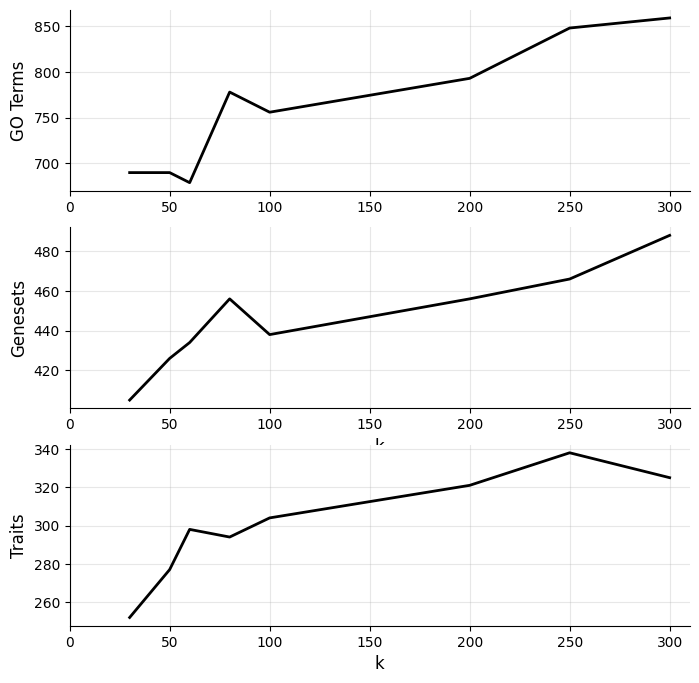

In [3]:
count_df = load_enrichment_data(folder, components = components)
plot_enrichment(count_df)

# Perturbation

min regulators is 203
max regulators is 240


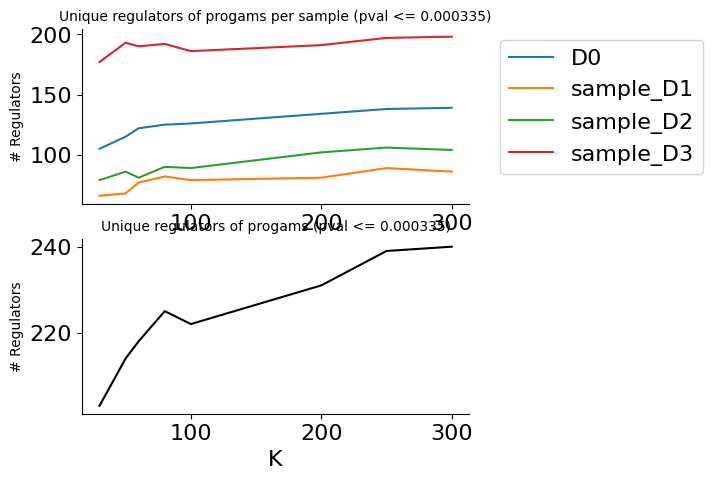

In [4]:
test_stats_df = load_perturbation_data(folder, components = components)

plot_perturbation(test_stats_df)

# Explained Variance

min Explained_variance is 8.259874562699387e-05
max Explained_variance is 0.0001551671141657


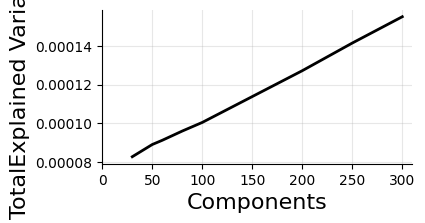

In [5]:
stats = load_explained_variance_data(folder, components=components)
plot_explained_variance(stats)

# Motif (working in progress for complie the results)

In [20]:
def collect_motif_data(k, path):

    motif_enrichment_data = []

    path = f'{path}/{k}'

    # import data 
    for fil in os.listdir(path):
        if 'motif_enrichment' in fil:
            motif_enrichment_data_ = pd.read_csv('{}/{}'.format(path,fil), sep='\t')
            motif_enrichment_data_['sample'] = fil.split('sample_')[-1].split('_motif')[0]
            if 'promoter' in fil:
                motif_enrichment_data_['class'] = 'promoter'
            elif 'enhancer' in fil:
                motif_enrichment_data_['class'] = 'enhancer'            

            motif_enrichment_data.append(motif_enrichment_data_)

    motif_enrichment_data = pd.concat(motif_enrichment_data, ignore_index=True)
    motif_enrichment_data.rename(columns={"adj_pval": "Adjusted P-value"}, inplace=True)

    motif_enrichment_data.to_csv(f'{path}/{k}_motif_enrichment.txt', sep='\t')
    motif_enrichment_data.loc[motif_enrichment_data['class']=='promoter'].to_csv(f'{path}/{k}_motif_enrichment_promoter.txt', sep='\t')
    motif_enrichment_data.loc[motif_enrichment_data['class']=='enhancer'].to_csv(f'{path}/{k}_motif_enrichment_enhancer.txt', sep='\t')


    # Make summary table column
    for seq_class in ['promoter', 'enhancer']:
        motif_enrichment_data_ = motif_enrichment_data.loc[motif_enrichment_data['class']==seq_class]
        motif_enrichment_data_ = motif_enrichment_data_.groupby(['sample', 'program_name', 'motif']).min().reset_index()

        motif_summary_data = pd.DataFrame(index=motif_enrichment_data_.program_name.unique(), columns=['top10_motifs', 'num_enriched_motifs'])
        for prog in motif_enrichment_data_.program_name.unique():
            motif_summary_data_ = motif_enrichment_data_.loc[(motif_enrichment_data_.program_name==prog) & ((motif_enrichment_data_["Adjusted P-value"]<=0.05))]
            motif_summary_data_ = motif_summary_data_.sort_values('stat', ascending=False).head(10).motif.values
            motif_summary_data.loc[prog,'top10_motifs'] = ', '.join(motif_summary_data_.tolist())
            motif_summary_data.loc[prog, 'num_enriched_motifs'] = motif_enrichment_data_.loc[(motif_enrichment_data_.program_name==prog) & ((motif_enrichment_data_.adj_pval<=0.05))].shape[0]
            
        motif_summary_data.to_csv('{}/motif_summary_data_{}.txt'.format(path,seq_class), sep='\t')
        

def collect_motif_all(path, components = [30, 50, 60, 80, 100, 200, 250, 300]):

    for k in components:
        collect_motif_data(k, path)
    
collect_motif_all(path)

In [ ]:
path = '/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation/090425_100k_cells_10iter_torch_mu_online/Eval/'


collect_motif_data(50,path)

In [4]:
    
# # Copy out to dashboard
# out_dir = '../../shared/250110_ipsc_ec_dashboard_setup/cNMF_100/'
# for fil in os.listdir('cNMF_100'):
#     if 'motif_' in fil:
#         class_ = fil.split('_')[1]
#         name = fil.split('_sample_')[1]
#         new_nam = f'cNMF_100_{class_}_test_pearsonr_sample_{name}'
#         if not name.startswith('D0'):
#             new_nam = new_nam.replace('sample_', 'sample_sample_')
#         os.system('cp {} {}'.format(os.path.join('cNMF_100', fil),
#                                     os.path.join(out_dir, new_nam)))